In [1]:
import numpy as np

In [2]:
mnist2d_points = np.load("mnist2d-points.npy")
mnist2d_labels = np.load("mnist2d-labels.npy")

In [3]:
mnist2d_points.shape, mnist2d_labels.shape

((70000, 400, 2), (70000, 1))

In [4]:
X_train, X_test = mnist2d_points[:60000], mnist2d_points[60000:]
y_train, y_test = mnist2d_labels[:60000], mnist2d_labels[60000:]

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((60000, 400, 2), (10000, 400, 2), (60000, 1), (10000, 1))

In [6]:
def get_examples(n_examples):
    """
    - takes number of examples as input
    - returns random subset of examples from X_train, rotated examples, angles of rotation and original labels 
    """
    global X_train, y_train
    
    ix = np.random.choice(range(len(X_train)), size=n_examples)
    
    examples = X_train[ix]
    theta = np.pi / 2 * np.random.rand(n_examples) # theta in [0, pi / 2]
    
    
    rotated_examples = []
    for i in range(n_examples):
        rotation_matrix = np.array([[np.cos(-theta[i]), np.sin(-theta[i])],
                                    [-np.sin(-theta[i]), np.cos(-theta[i])]])
        
        rotated_examples.append(np.dot(examples[i], rotation_matrix))
    
    rotated_examples = np.array(rotated_examples)
    delta = np.array([0.5, 0.5]) - rotated_examples.mean(axis=1).reshape(n_examples, 1, 2)
    
    rotated_examples += delta
    theta = theta.reshape(-1, 1, 1)
    return examples, rotated_examples, theta, y_train[ix]

In [7]:
examples, rotated_examples, theta, labels = get_examples(2000)

In [8]:
import matplotlib.pyplot as plt

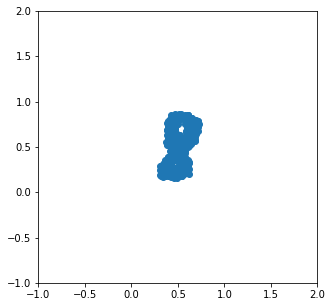

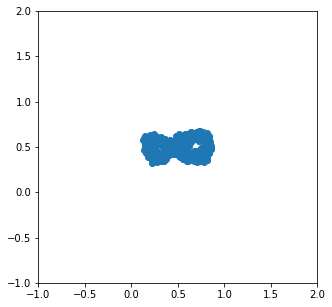

[8]


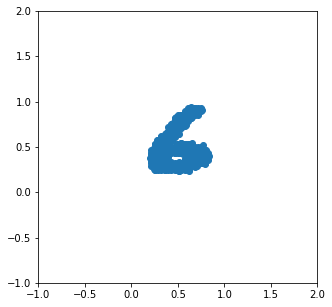

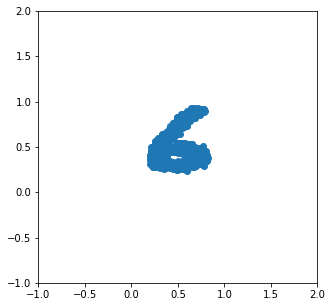

[6]


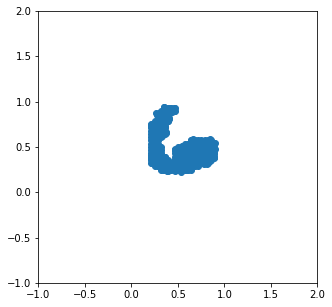

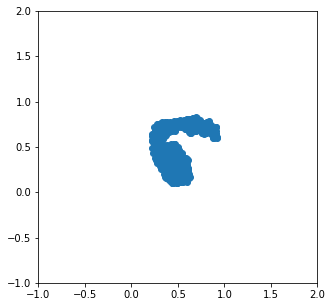

[6]


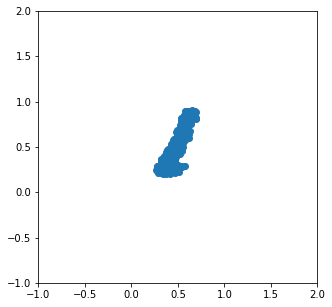

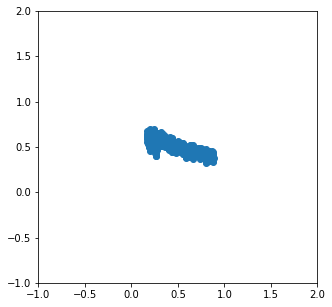

[1]


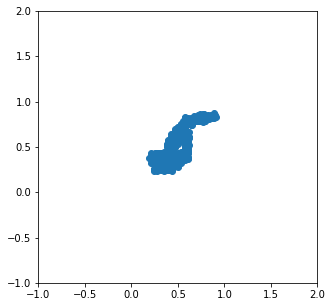

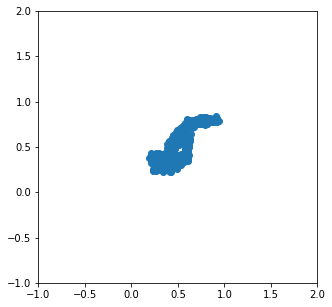

[5]


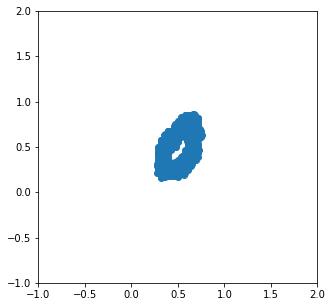

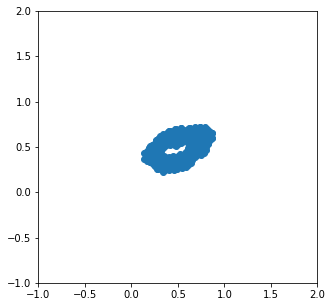

[0]


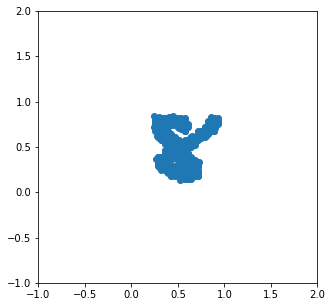

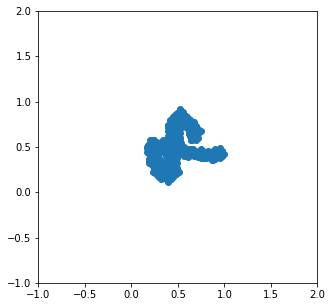

[8]


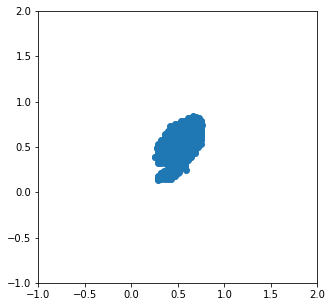

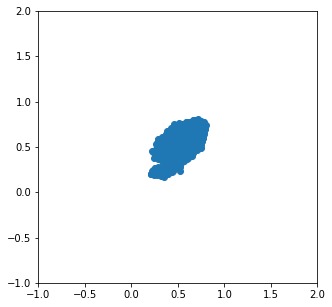

[9]


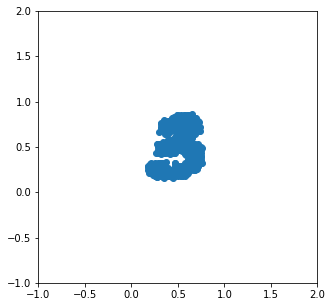

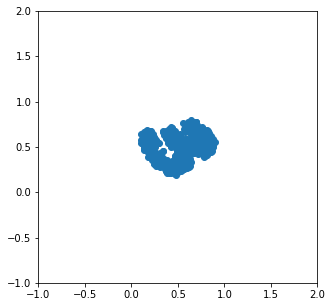

[3]


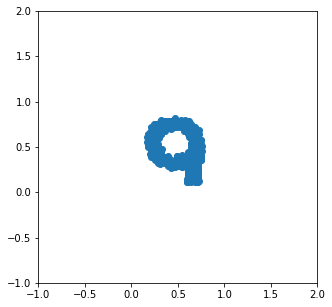

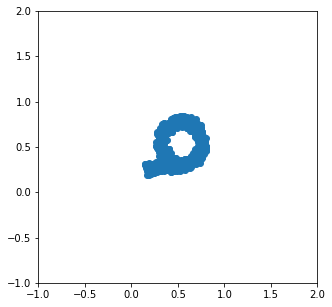

[9]


In [9]:
for i in range(min(len(examples), 10)):
    plt.figure(figsize=(5, 5))
    plt.scatter(examples[i][:, 0], examples[i][:, 1])
    plt.xlim(-1, 2)
    plt.ylim(-1, 2)
    plt.show()

    plt.figure(figsize=(5, 5))
    plt.scatter(rotated_examples[i][:, 0], rotated_examples[i][:, 1])
    plt.xlim(-1, 2)
    plt.ylim(-1, 2)
    plt.show()
    
    print(labels[i])

In [10]:
import numpy as np
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import tensorflow as tf
from keras import optimizers
from keras.layers import Input
from keras.models import Model
from keras.layers import Dense, Reshape
from keras.layers import Convolution1D, MaxPooling1D, BatchNormalization
from keras.layers import Lambda, concatenate
#from keras.utils import np_utils
import h5py


def mat_mul(A, B):
    return tf.matmul(A, B)


def exp_dim(global_feature, num_points):
    return tf.tile(global_feature, [1, num_points, 1])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)
Using TensorFlow backend.


In [11]:
num_points = 400
# epoch number
epo = 50
# define optimizer
adam = optimizers.Adam(lr=0.001, decay=0.7)

'''
Pointnet Architecture
'''
# input_Transformation_net
input_points = Input(shape=(num_points, 2))
x = Convolution1D(64, 1, activation='relu',
                  input_shape=(num_points, 2))(input_points)
x = BatchNormalization()(x)
x = Convolution1D(128, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = Convolution1D(1024, 1, activation='relu')(x)
x = BatchNormalization()(x)
x = MaxPooling1D(pool_size=num_points)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dense(4, weights=[np.zeros([256, 4]), np.array([1, 0, 0, 1]).astype(np.float32)])(x)
input_T = Reshape((2, 2))(x)

# forward net
g = Lambda(mat_mul, arguments={'B': input_T})(input_points)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(64, 1, input_shape=(num_points, 3), activation='relu')(g)
g = BatchNormalization()(g)

# feature transformation net
f = Convolution1D(64, 1, activation='relu')(g)
f = BatchNormalization()(f)
f = Convolution1D(128, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = Convolution1D(1024, 1, activation='relu')(f)
f = BatchNormalization()(f)
f = MaxPooling1D(pool_size=num_points)(f)
f = Dense(512, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(256, activation='relu')(f)
f = BatchNormalization()(f)
f = Dense(64 * 64, weights=[np.zeros([256, 64 * 64]), np.eye(64).flatten().astype(np.float32)])(f)
feature_T = Reshape((64, 64))(f)

# forward net
g = Lambda(mat_mul, arguments={'B': feature_T})(g)
seg_part1 = g
g = Convolution1D(64, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(128, 1, activation='relu')(g)
g = BatchNormalization()(g)
g = Convolution1D(1024, 1, activation='relu')(g)
g = BatchNormalization()(g)

# global_feature

input_angle = Input(shape=(1, 1))

global_feature = MaxPooling1D(pool_size=num_points)(g)
global_feature = concatenate([global_feature, input_angle])
global_feature = Lambda(exp_dim, arguments={'num_points': num_points})(global_feature)

# point_net_seg
c = concatenate([seg_part1, global_feature])
c = Convolution1D(512, 1, activation='relu')(c)
c = BatchNormalization()(c)
c = Convolution1D(256, 1, activation='relu')(c)
c = BatchNormalization()(c)
c = Convolution1D(128, 1, activation='relu')(c)
c = BatchNormalization()(c)
c = Convolution1D(128, 1, activation='relu')(c)
c = BatchNormalization()(c)
prediction = Convolution1D(2, 1)(c)

model = Model(input=[input_points, input_angle], output=prediction)
'''
end of pointnet
'''

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel/__main__.py:79: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("co..., inputs=[<tf.Tenso...)`


'\nend of pointnet\n'

In [12]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 2)       0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 400, 2)       0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 400, 64)      192         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_6 (BatchNor (None, 400, 64)      256         conv1d_4[0][0]                   
__________________________________________________________________________________________________
conv1d_5 (

In [13]:
model.compile(optimizer='adam',
              loss='mse')

In [14]:
model.fit([examples, theta], rotated_examples, validation_split=0.3, batch_size=32, epochs=50, shuffle=True)

Train on 1400 samples, validate on 600 samples
Epoch 1/50
1400/1400 [==============================] - 194s 139ms/step - loss: 0.5555 - val_loss: 1.0434

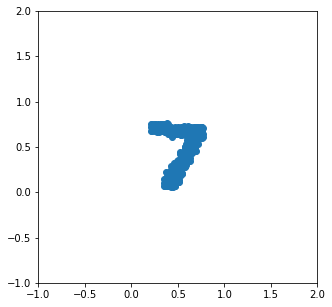

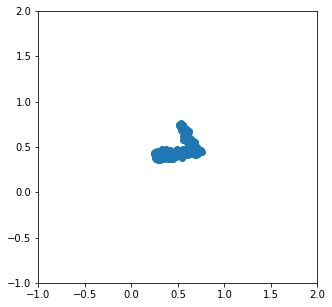

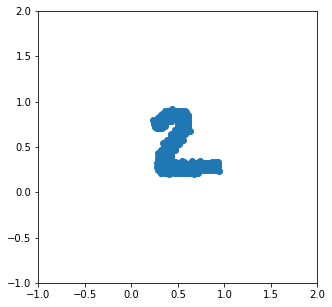

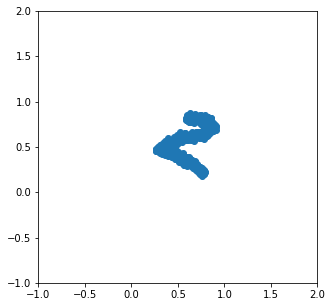

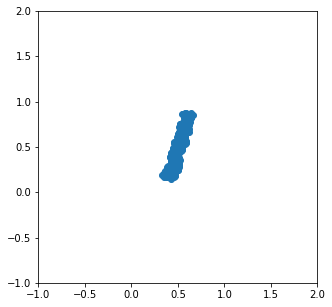

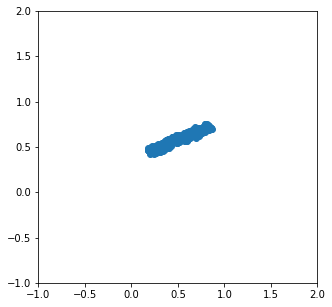

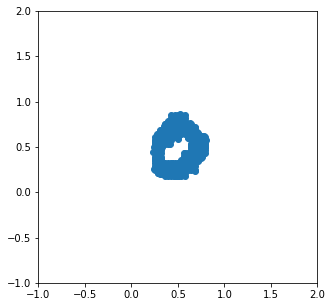

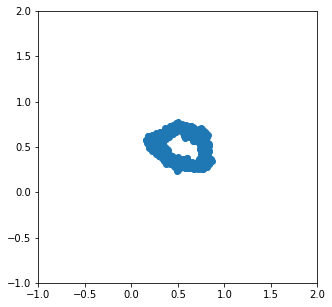

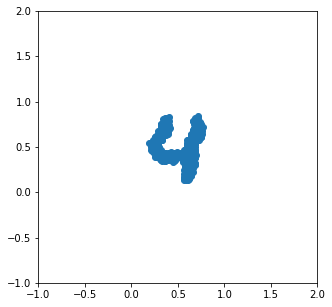

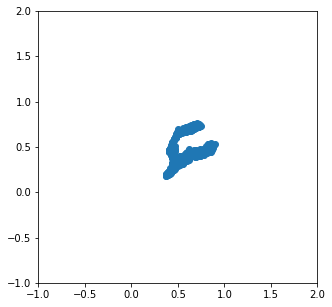

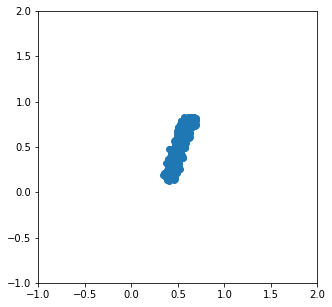

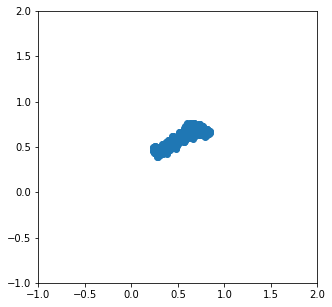

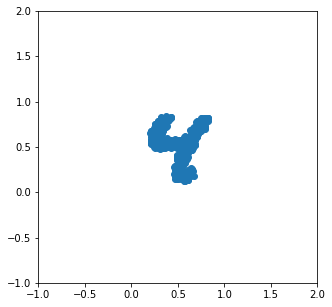

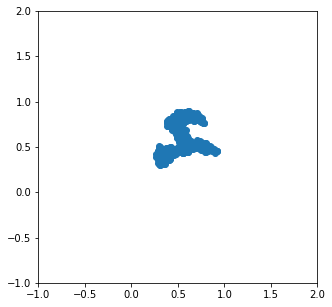

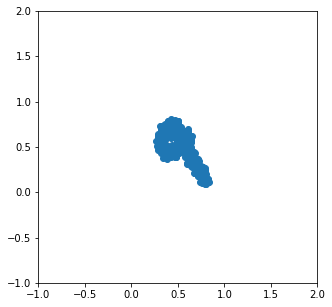

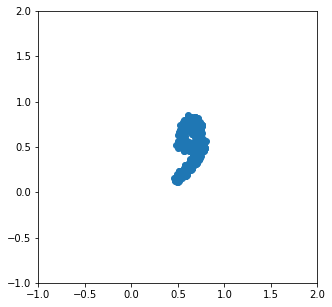

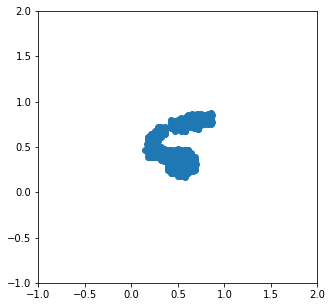

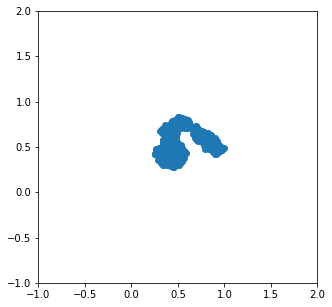

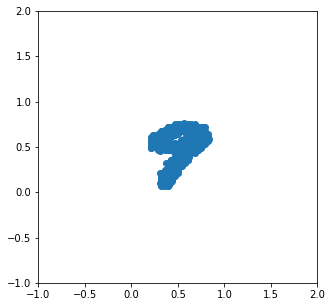

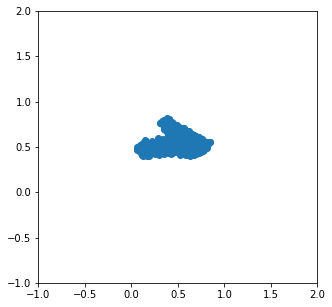

In [16]:
for i in range(10):
    y = model.predict([X_test[i].reshape(1, 400, 2), np.array(np.pi / 6).reshape(-1, 1, 1)])
    y = y.reshape(y.shape[1], y.shape[2])
    
    plt.figure(figsize=(5, 5))
    plt.scatter(X_test[i][:, 0], X_test[i][:, 1])
    plt.xlim(-1, 2)
    plt.ylim(-1, 2)
    plt.show()

    y = y
    plt.figure(figsize=(5, 5))
    plt.scatter(y[:, 0], y[:, 1])
    plt.xlim(-1, 2)
    plt.ylim(-1, 2)
    plt.show()